# Векторизация контента

Сегодня рассмотрим способы представления контента в виде вектора (эмбеддинга).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from collections import Counter
import cv2
from glob import glob
import imageio
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import os
import pandas as pd
import pprint
import random
import string
from skimage import feature
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
from torchvision.models import vgg16 # модель семейства VGG
from torchvision.models import resnet18 # модель семейства ResNet
import torchvision.transforms as transforms # для предобработки изображений

from PIL import Image # для работы с изображениями

## One-hot encoding

In [3]:
documents = ['data science is one of the most important fields of science',
             'this is one of the best data science courses',
             'data scientists analyze data' ]

lower_case_documents = []
for i in documents:
    lower_case_documents.append(i.lower())
print(lower_case_documents)

['data science is one of the most important fields of science', 'this is one of the best data science courses', 'data scientists analyze data']


In [4]:
without_punctuation_documents = []
for i in lower_case_documents:
    without_punctuation_documents.append(''.join(c for c in i if c not in string.punctuation))

print(without_punctuation_documents)

['data science is one of the most important fields of science', 'this is one of the best data science courses', 'data scientists analyze data']


In [5]:
preprocessed_documents = []
for i in without_punctuation_documents:
    preprocessed_documents.append(i.split(' '))
print(preprocessed_documents)

[['data', 'science', 'is', 'one', 'of', 'the', 'most', 'important', 'fields', 'of', 'science'], ['this', 'is', 'one', 'of', 'the', 'best', 'data', 'science', 'courses'], ['data', 'scientists', 'analyze', 'data']]


In [6]:
all_words = sorted(list(set([word for document in preprocessed_documents for word in document])))

print(all_words)

['analyze', 'best', 'courses', 'data', 'fields', 'important', 'is', 'most', 'of', 'one', 'science', 'scientists', 'the', 'this']


In [ ]:
onehot_vectors = pd.DataFrame(np.zeros((len(documents), len(all_words))), columns=list(all_words))
onehot_vectors

analyze  best  courses  data  fields  important   is  most   of  one  \
0      0.0   0.0      0.0   0.0     0.0        0.0  0.0   0.0  0.0  0.0   
1      0.0   0.0      0.0   0.0     0.0        0.0  0.0   0.0  0.0  0.0   
2      0.0   0.0      0.0   0.0     0.0        0.0  0.0   0.0  0.0  0.0   

   science  scientists  the  this  
0      0.0         0.0  0.0   0.0  
1      0.0         0.0  0.0   0.0  
2      0.0         0.0  0.0   0.0

In [ ]:
for i, document in enumerate(preprocessed_documents):
  for word in document:
    onehot_vectors[word].iloc[i] = 1

In [ ]:
onehot_vectors

analyze  best  courses  data  fields  important   is  most   of  one  \
0      0.0   0.0      0.0   1.0     1.0        1.0  1.0   1.0  1.0  1.0   
1      0.0   1.0      1.0   1.0     0.0        0.0  1.0   0.0  1.0  1.0   
2      1.0   0.0      0.0   1.0     0.0        0.0  0.0   0.0  0.0  0.0   

   science  scientists  the  this  
0      1.0         0.0  1.0   0.0  
1      1.0         0.0  1.0   1.0  
2      0.0         1.0  0.0   0.0

## BoW
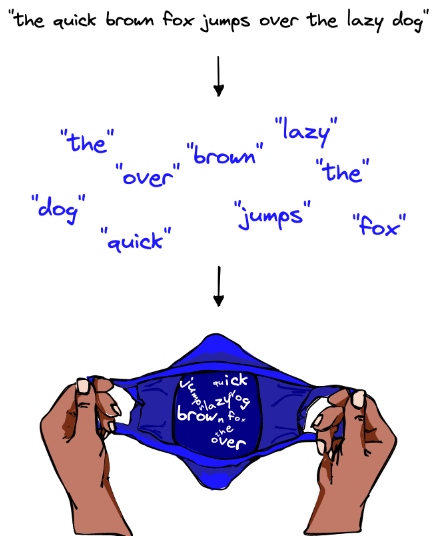

Источник изображения: https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/

In [7]:
documents = ['data science is one of the most important fields of science',
             'this is one of the best data science courses',
             'data scientists analyze data' ]

Воспользуемся препроцессингом с предыдущей части

In [8]:
frequency_list = []
for i in preprocessed_documents:
  frequency_list.append(Counter(i))

pprint.pprint(frequency_list)

[Counter({'science': 2,
          'of': 2,
          'data': 1,
          'is': 1,
          'one': 1,
          'the': 1,
          'most': 1,
          'important': 1,
          'fields': 1}),
 Counter({'this': 1,
          'is': 1,
          'one': 1,
          'of': 1,
          'the': 1,
          'best': 1,
          'data': 1,
          'science': 1,
          'courses': 1}),
 Counter({'data': 2, 'scientists': 1, 'analyze': 1})]


In [ ]:
# соберем список всех уникальных слов
all_words = [list(row.elements()) for row in frequency_list]
all_words = list(set([word for words in all_words for word in words]))

# сформируем BOW-матрицу
bow_matrix = np.zeros((len(documents), len(all_words)))

for i, cur_frequency_list in enumerate(frequency_list):
  for j, word in enumerate(all_words):
    bow_matrix[i, j] = cur_frequency_list[word]

print(bow_matrix)

[[0. 1. 0. 0. 1. 2. 1. 1. 0. 1. 2. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]
 [1. 0. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## TF-IDF
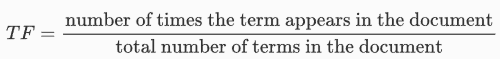

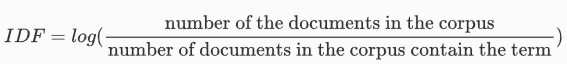

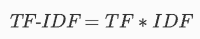

In [9]:
corpus = ['data science is one of the most important fields of science',
          'this is one of the best data science courses',
          'data scientists analyze data' ]

In [10]:
words_set = set()

for doc in corpus:
    words = doc.split(' ')
    words_set = words_set.union(set(words))

n_docs = len(corpus)          # число документов в корпусе
n_words_set = len(words_set)  # число уникальных слов в корпусе

print('число документов в корпусе: ', n_docs)
print('число уникальных слов в корпусе: ', n_words_set)
print('Слова корпуса: \n', words_set)

число документов в корпусе:  3
число уникальных слов в корпусе:  14
Слова корпуса: 
 {'fields', 'one', 'data', 'important', 'of', 'science', 'courses', 'analyze', 'this', 'best', 'scientists', 'most', 'the', 'is'}


In [11]:
df_tf = pd.DataFrame(np.zeros((n_docs, n_words_set)), columns=list(words_set))
df_tf

fields  one  data  important   of  science  courses  analyze  this  best  \
0     0.0  0.0   0.0        0.0  0.0      0.0      0.0      0.0   0.0   0.0   
1     0.0  0.0   0.0        0.0  0.0      0.0      0.0      0.0   0.0   0.0   
2     0.0  0.0   0.0        0.0  0.0      0.0      0.0      0.0   0.0   0.0   

   scientists  most  the   is  
0         0.0   0.0  0.0  0.0  
1         0.0   0.0  0.0  0.0  
2         0.0   0.0  0.0  0.0

In [13]:
# вычислим Term Frequency (TF)
for i in range(n_docs):
    words = corpus[i].split(' ') # Words in the document
    for word in words:
        df_tf[word][i] += (1 / len(words))

# посмотрим на частоту каждого слова в каждом документе
df_tf

fields       one      data  important        of   science   courses  \
0  0.181818  0.181818  0.181818   0.181818  0.363636  0.363636  0.000000   
1  0.000000  0.222222  0.222222   0.000000  0.222222  0.222222  0.222222   
2  0.000000  0.000000  1.000000   0.000000  0.000000  0.000000  0.000000   

   analyze      this      best  scientists      most       the        is  
0      0.0  0.000000  0.000000         0.0  0.181818  0.181818  0.181818  
1      0.0  0.222222  0.222222         0.0  0.000000  0.222222  0.222222  
2      0.5  0.000000  0.000000         0.5  0.000000  0.000000  0.000000

In [14]:
# вычислим Inverse Document Frequency (IDF)
print("IDF of: ")

idf = {}
for word in words_set:
    k = 0    # число документов в корпусе, которые содержат это слово
    for i in range(n_docs):
        if word in corpus[i].split():
            k += 1

    idf[word] =  np.log10(n_docs / k)

    print(f'{word:>15}: {idf[word]}')

# заметим, что "data" имеет IDF = 0, так как оно появляется в каждом документе

IDF of: 
         fields: 0.47712125471966244
            one: 0.17609125905568124
           data: 0.0
      important: 0.47712125471966244
             of: 0.17609125905568124
        science: 0.17609125905568124
        courses: 0.47712125471966244
        analyze: 0.47712125471966244
           this: 0.47712125471966244
           best: 0.47712125471966244
     scientists: 0.47712125471966244
           most: 0.47712125471966244
            the: 0.17609125905568124
             is: 0.17609125905568124


In [15]:
# теперь посчитаем tf-idf
df_tf_idf = df_tf.copy()

for w in words_set:
    for i in range(n_docs):
        df_tf_idf[w][i] = df_tf[w][i] * idf[w]

df_tf_idf

fields       one  data  important        of   science   courses  \
0  0.086749  0.032017   0.0   0.086749  0.064033  0.064033  0.000000   
1  0.000000  0.039131   0.0   0.000000  0.039131  0.039131  0.106027   
2  0.000000  0.000000   0.0   0.000000  0.000000  0.000000  0.000000   

    analyze      this      best  scientists      most       the        is  
0  0.000000  0.000000  0.000000    0.000000  0.086749  0.032017  0.032017  
1  0.000000  0.106027  0.106027    0.000000  0.000000  0.039131  0.039131  
2  0.238561  0.000000  0.000000    0.238561  0.000000  0.000000  0.000000

Рассмотрим пример с scikit-learn

In [16]:
# поставим библиотеку для лемматизации русских слов
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=ef02f9931b0510906ee181d51913f4253703e5ea2df6b47eb1e750ea7454ebec
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [17]:
# для токенизации, удаления стоп-слов
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

# для лемматизации
import pymorphy2

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
def preprocess_text(text):
  """ Извлечение слов из документа """
  # для лемматизации
  morph = pymorphy2.MorphAnalyzer()

  # определим русские стоп-слова
  russian_stopwords = stopwords.words("russian")

  # разделяем текст на отдельные слова, приводим к нижнему регистру
  text_tokens = word_tokenize(text.lower(), language="russian")

  # удаляем стоп-слова и знаки пунктуации
  tokens_without_sw = [word for word in text_tokens if word not in russian_stopwords and word.isalpha()]

  # приводим слова в нормальную форму
  words = list(set([morph.parse(token)[0].normal_form for token in tokens_without_sw]))

  return ' '. join(words)

In [19]:
# пример текстовых данных
documents = [
    "Машинное обучение - это интересная область.",
    "Обучение с учителем - ключевой аспект машинного обучения.",
    "Область NLP также связана с машинным обучением."
]

In [20]:
documents_preprocessed = []

for document in documents:
  documents_preprocessed.append(preprocess_text(document))

In [21]:
documents_preprocessed[0]

'это обучение область интересный машинный'

In [22]:
# Создание объекта TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

In [23]:
# Применение TF-IDF к текстовым данным
tfidf_matrix = tfidf_vectorizer.fit_transform(documents_preprocessed)

In [24]:
# Получение списка ключевых слов и их значения TF-IDF для первого документа
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()[0]

# Сортировка слов по значениям TF-IDF
sorted_keywords = [(_, word) for _, word in sorted(zip(tfidf_scores, feature_names), reverse=True)]

print("Ключевые слова:", sorted_keywords)

Ключевые слова: [(0.5524900470844099, 'это'), (0.5524900470844099, 'интересный'), (0.4201829214890553, 'область'), (0.32630952195289625, 'обучение'), (0.32630952195289625, 'машинный'), (0.0, 'учитель'), (0.0, 'также'), (0.0, 'связать'), (0.0, 'ключевой'), (0.0, 'аспект'), (0.0, 'nlp')]


In [25]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.55249005, 0.        , 0.32630952,
         0.42018292, 0.32630952, 0.        , 0.        , 0.        ,
         0.55249005],
        [0.        , 0.52004008, 0.        , 0.52004008, 0.30714405,
         0.        , 0.30714405, 0.        , 0.        , 0.52004008,
         0.        ],
        [0.48359121, 0.        , 0.        , 0.        , 0.28561676,
         0.36778358, 0.28561676, 0.48359121, 0.48359121, 0.        ,
         0.        ]])

## Word2Vec  
### CBOW (Continuous Bag of Words) & Skip-gram (https://arxiv.org/abs/1301.3781v3)
- CBOW: предсказание слова в зависимости от контекста, в котором находится слово. CBOW: предсказывает текущее слово на основе контекста (окружающих слов). Например, в предложении "Собака лает на ___", CBOW попытается угадать недостающее слово (например, "почтальона") на основе окружающих слов.CBOW обучается быстрее, чем skip-gram, и может лучше представлять часто встречающиеся слова.  

- Skip-gram: попытаться предсказать слова контекста, используя целевое слово. Skip-gram: работает наоборот по сравнению с CBOW. Использует текущее слово для предсказания окружающих его слов в предложении. Например, если взять слово "кошка", модель попытается предсказать слова, которые часто встречаются в окружении слова "кошка", такие как "мышь", "мяукает" и т.д. Skip-gram хорошо работает с небольшими наборами данных и может лучше представлять редкие слова.

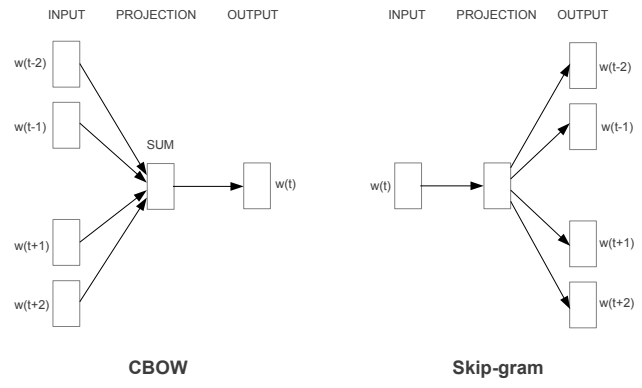  

king – man + woman = queen // т.е. король - мужчина + женщина = королева


Технически этот подход прогнозирует вероятность того или иного слова быть контекстом для заданного слова. Показатели вероятности появления того или иного слова в результирующем выражении показывают, насколько вероятно увидеть то или иное слово из словаря рядом с входным словом.

In [26]:
!pip install gensim

In [28]:
from gensim.models import Word2Vec

docs = [
  'У лукоморья дуб зелёный; Златая цепь на дубе том: И днём и ночью кот учёный Всё ходит по цепи кругом; Идёт направо — песнь заводит, Налево — сказку говорит. Там чудеса: там леший бродит, Русалка на ветвях сидит; Там на неведомых дорожках Следы невиданных зверей; Избушка там на курьих ножках Стоит без окон, без дверей; Там лес и дол видений полны; Там о заре прихлынут волны На брег песчаный и пустой, И тридцать витязей прекрасных Чредой из вод выходят ясных,',
  'Я к вам пишу — чего же боле? Что я могу еще сказать? Теперь, я знаю, в вашей воле Меня презреньем наказать. Но вы, к моей несчастной доле Хоть каплю жалости храня, Вы не оставите меня. Сначала я молчать хотела; Поверьте: моего стыда Вы не узнали б никогда, Когда б надежду я имела Хоть редко, хоть в неделю раз В деревне нашей видеть вас, Чтоб только слышать ваши речи, Вам слово молвить, и потом Все думать, думать об одном И день и ночь до новой встречи. Но, говорят, вы нелюдим;',
  'Мороз и солнце; день чудесный! Еще ты дремлешь, друг прелестный — Пора, красавица, проснись: Открой сомкнуты негой взоры Навстречу северной Авроры, Звездою севера явись! Вечор, ты помнишь, вьюга злилась, На мутном небе мгла носилась; Луна, как бледное пятно, Сквозь тучи мрачные желтела, И ты печальная сидела — А нынче… погляди в окно: Под голубыми небесами Великолепными коврами, Блестя на солнце, снег лежит; Прозрачный лес один чернеет, И ель сквозь иней зеленеет,',
  'На берегу пустынных волн Стоял он, дум великих полн, И вдаль глядел. Пред ним широко Река неслася; бедный чёлн По ней стремился одиноко. По мшистым, топким берегам Чернели избы здесь и там, Приют убогого чухонца; И лес, неведомый лучам В тумане спрятанного солнца, Кругом шумел. И думал он: Отсель грозить мы будем шведу, Здесь будет город заложен На зло надменному соседу. Природой здесь нам суждено В Европу прорубить окно,',
  'Унылая пора! Очей очарованье! Приятна мне твоя прощальная краса — Люблю я пышное природы увяданье, В багрец и в золото одетые леса, В их сенях ветра шум и свежее дыханье, И мглой волнистою покрыты небеса, И редкий солнца луч, и первые морозы, И отдаленные седой зимы угрозы.'
]

# список предложений, где каждое предложение - список слов
sentences = []
for doc in docs:
  doc = doc.lower()
  for pr in [';', ':', '?', '!', ',', '.', '—', '…']:
    doc = doc.replace(pr, '')
  sentences.append(doc.split(' '))

# создание модели Word2Vec
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [29]:
# word2vec обучается на текстовых данных
model.train(sentences, total_examples=model.corpus_count, epochs=10)

(2768, 3570)

In [30]:
# получение вектора слова
vector = model.wv['дуб']

# поиск похожих слов
similar_words = model.wv.most_similar('дуб')

In [31]:
vector

array([-0.00173535,  0.00264226,  0.00551238, -0.00012236,  0.00027403,
       -0.00389096,  0.00889292, -0.00747021, -0.00288984, -0.00459113,
        0.0035473 ,  0.00219708, -0.00098066,  0.00024337, -0.00684301,
       -0.00138874,  0.00757119,  0.00107902,  0.00943365, -0.00312854,
        0.00254182,  0.00034227,  0.00118343,  0.00129737,  0.00763658,
        0.00448004, -0.00211879,  0.00900843,  0.00791669, -0.00560474,
        0.00020669,  0.00973452, -0.00767436,  0.00976476,  0.00818982,
        0.00655758, -0.0027201 ,  0.00401998,  0.00267613, -0.00917857,
       -0.00045172,  0.00527298, -0.00431207,  0.00232865,  0.00374956,
       -0.00509502,  0.0065259 , -0.00536069, -0.00934851, -0.00330817,
       -0.00158218, -0.0036853 ,  0.00469725, -0.00195032,  0.00015232,
        0.00098733,  0.0092642 ,  0.0059267 , -0.00669688, -0.00192472,
        0.00178216, -0.00941347, -0.00469018,  0.00355446,  0.00743278,
       -0.01014775, -0.00080006, -0.00020795,  0.00662463,  0.00

In [32]:
similar_words

[('чего', 0.2939586341381073),
 ('первые', 0.2505638301372528),
 ('пышное', 0.2299361228942871),
 ('еще', 0.22431397438049316),
 ('окон', 0.20257487893104553),
 ('об', 0.19706639647483826),
 ('лучам', 0.195433109998703),
 ('несчастной', 0.17898733913898468),
 ('цепи', 0.17776240408420563),
 ('б', 0.1775592863559723)]

## BERT
Bidirectional Encoder Representations from Transformers  
Имеет архитектуру Transformer.  
Обучался для masked language model (MLM) и next sentence prediction (NSP) task.

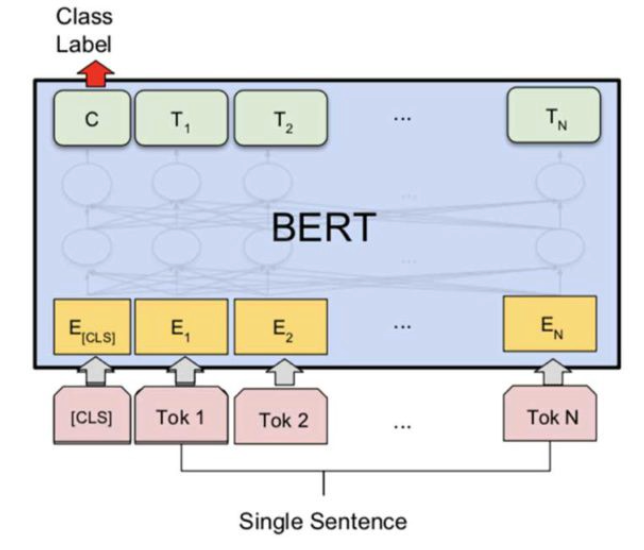

Нас интересует только скрытое состояние, связанное с исходным токеном [CLS] , которое лучше других отражает семантику всего предложения.

In [33]:
!pip install transformers

In [34]:
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [36]:
# входные данные BERT — это не исходные слова, а токены
tokenized_docs = tokenizer(docs, padding=True, truncation=True, return_tensors="pt")
print(tokenized_docs.keys())

dict_keys(['input_ids', 'attention_mask'])


In [37]:
tokenized_docs["input_ids"] = tokenized_docs["input_ids"].to(device)
tokenized_docs["attention_mask"] = tokenized_docs["attention_mask"].to(device)

In [38]:
with torch.no_grad():
  docs_hidden = model(**tokenized_docs) #dim : [batch_size(nr_sentences), tokens, emb_dim]

# get only the [CLS] hidden states
docs_embeddings = docs_hidden.last_hidden_state[:,0,:]
docs_embeddings.shape

torch.Size([5, 768])

In [39]:
docs_embeddings[0]

tensor([-2.7793e-01,  1.8631e-01, -9.2466e-02, -3.6592e-01, -8.3404e-03,
         6.8394e-02,  2.1269e-01,  1.7447e-01, -2.3366e-01, -8.8334e-02,
        -1.4614e-01, -1.4124e-01, -1.9058e-01, -2.1458e-02, -3.0900e-01,
         1.5422e-01,  4.5882e-02, -7.4484e-03,  8.1533e-03,  1.3988e-01,
         4.9025e-02, -1.3119e-01,  1.8992e-01,  1.9555e-01, -5.1625e-01,
        -1.8007e-01, -2.4137e-01,  4.0080e-01,  1.7346e-01,  3.3766e-01,
        -8.4204e-02,  9.4290e-02, -1.2344e-01,  1.5730e-01,  1.7371e-01,
         2.7798e-01, -4.2023e-02, -2.3198e-01, -4.1239e-03, -2.5487e-01,
        -4.1821e-02,  2.9358e-01, -2.9934e-01, -4.6703e-01,  1.3056e-01,
        -4.1623e-01, -3.1396e+00,  3.5472e-01, -2.5699e-01, -5.2551e-01,
         5.2314e-01, -2.1999e-01,  2.3273e-01, -3.9425e-01, -2.1660e-01,
         5.1231e-01, -2.5487e-01,  1.9527e-01, -7.5871e-02,  2.6695e-01,
         1.4779e-01,  4.6542e-01, -6.2532e-02,  2.8034e-02,  2.3175e-01,
         8.5643e-02, -3.5158e-01,  5.7085e-01, -2.9

## Извлечение векторов признаков из изображений

Для демонстрации примеров векторизации изображений на практике будем использовать часть датасета с лицами животных:
https://www.kaggle.com/datasets/andrewmvd/animal-faces

In [40]:
# распакуем архив с данными
!unzip -qq "/content/drive/MyDrive/ITMO/Информационный поиск/in class/02_vectorization/animal_faces_wild.zip"

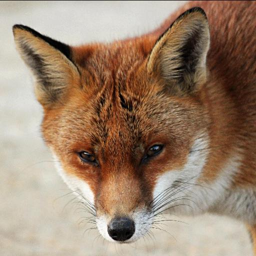

In [41]:
image1_path = '/content/animal_faces_wild/flickr_wild_000004.jpg'
Image.open(image1_path).resize((256, 256))

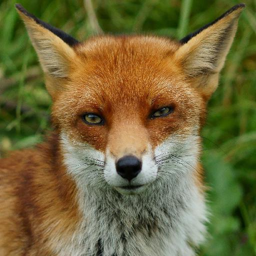

In [42]:
image2_path = '/content/animal_faces_wild/flickr_wild_000017.jpg'
Image.open(image2_path).resize((256, 256))

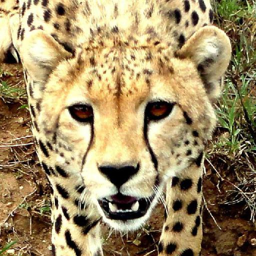

In [43]:
image3_path = '/content/animal_faces_wild/flickr_wild_000557.jpg'
Image.open(image3_path).resize((256, 256))

### VGG
  
Попробуем получить вектор изображения с помощью одной из моделей из семейства VGG (https://arxiv.org/abs/1409.1556).

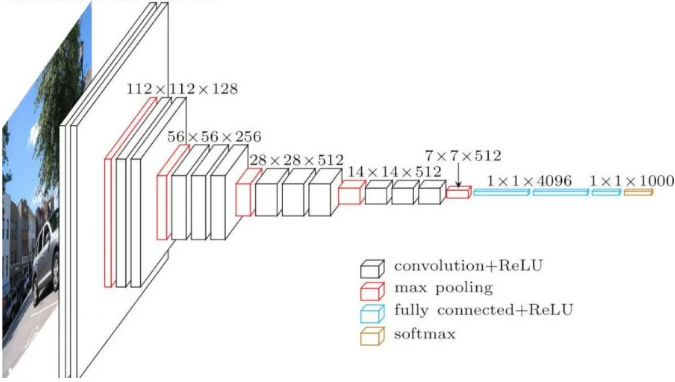

Источник изображения: https://neurohive.io/ru/vidy-nejrosetej/vgg16-model/

In [46]:
# укажем разрешение
resolution = 224

# в качестве устройства будем использовать видеокарту, для этого укажем 'cuda:0'
device = 'cuda:0' # 'cpu'

# трансформации для изображений для правильной подачи в нейронную сеть
transform = transforms.Compose([
    transforms.Resize((resolution, resolution)), #
    transforms.ToTensor(), # height, width, channels -> channels, height, width
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# загружаем претрейн модели
model = vgg16(pretrained=True)

# убираем классифицирующую голову
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# переносим модель на GPU/CPU
model = model.to(device)

# переводим модель в режим "инференса" (т.е. модель сейчас не обучается, а рабо-
#                                       тает в режиме предсказания, обновлять
#                                       веса не нужно)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.8MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [47]:
# определим функцию для эмбеддинга изображения
def get_feature(image_path, model, transform, device='cuda:0'):
  # откроем изображение
  image = Image.open(image_path)

  # выполним трансформации, получим тензор
  image_tensor = transform(image)

  # добавим дополнительную размерность в начале
  image_tensor = image_tensor.unsqueeze(0) # 1, h, w, c

  # перенесем наш тензор на GPU/CPU
  image_tensor = image_tensor.to(device)

  # получим эмбеддинги в режиме no_grad - без вычислений градиентов
  with torch.no_grad():
    # подаем тензор изображения в модель, получаем тензор-эмбеддинг на выходе
    embedding = model(image_tensor)

    # переносим наш эмбеддинг на CPU
    embedding = embedding.cpu()

    # вытягиваем эмбеддинг в плоский вектор и приводим к формату numpy
    embedding = embedding.flatten().numpy()

  # возвращаем эмбеддинг
  return embedding

In [48]:
# получим эмбеддинги для этих 3-х изображений
feature1 = get_feature(image1_path, model, transform, device=device)
feature2 = get_feature(image2_path, model, transform, device=device)
feature3 = get_feature(image3_path, model, transform, device=device)

In [49]:
# посмотрим на размерность полученных векторов
print(feature1.shape, feature2.shape, feature3.shape)

(25088,) (25088,) (25088,)


In [51]:
# в качестве примера рассмотрим попарное расстояние между этими векторами

# определим функции расстояния
def cosine(v1, v2):
  return 1 - np.dot(v1,v2)/(norm(v1)*norm(v2))

def l1(v1, v2):
  return np.sum(np.abs(v1-v2))

def l2(v1, v2):
  return np.sqrt(np.sum((v1-v2)**2))

In [52]:
print("cosine: ", cosine(feature1, feature2), cosine(feature1, feature3), cosine(feature2, feature3))
print("L1: ", l1(feature1, feature2), l1(feature1, feature3), l1(feature2, feature3))
print("L2: ", l2(feature1, feature2), l2(feature1, feature3), l2(feature2, feature3))

cosine:  0.5019586086273193 0.7620790004730225 0.6603508591651917
L1:  19162.473 25429.863 24183.375
L2:  359.42828 439.75513 422.4381


Видим, что векторы изображений с лисами находятся ближе к друг другу относительно изображения с гепардом.

### ResNet
Аналогичным образом продемонстрируем пример работы с моделями семейства ResNet (https://arxiv.org/abs/1512.03385).

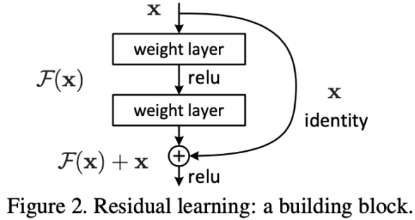

In [53]:
# укажем разрешение: по умолчанию, в семействе ResNet используется 224х224
resolution = 224

# в качестве устройства будем использовать видеокарту, для этого укажем 'cuda:0'
device = 'cuda:0' # 'cpu'

# трансформации для изображений для правильной подачи в нейронную сеть
transform = transforms.Compose([
    transforms.Resize((resolution, resolution)), #
    transforms.ToTensor(), # height, width, channels -> channels, height, width
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# загружаем претрейн модели
model = resnet18(pretrained=True)

# убираем классифицирующую голову
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# переносим модель на GPU/CPU
model = model.to(device)

# переводим модель в режим "инференса" (т.е. модель сейчас не обучается, а рабо-
#                                       тает в режиме предсказания, обновлять
#                                       веса не нужно)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [54]:
# получим эмбеддинги для этих 3-х изображений
feature1 = get_feature(image1_path, model, transform, device=device)
feature2 = get_feature(image2_path, model, transform, device=device)
feature3 = get_feature(image3_path, model, transform, device=device)

In [55]:
# посмотрим на размерность полученных векторов
print(feature1.shape, feature2.shape, feature3.shape)

(512,) (512,) (512,)


In [56]:
print(l2(feature1, feature2), l2(feature1, feature3), l2(feature2, feature3))

13.843834 29.452745 27.96683


## Bag of Visual Words (BoVW)
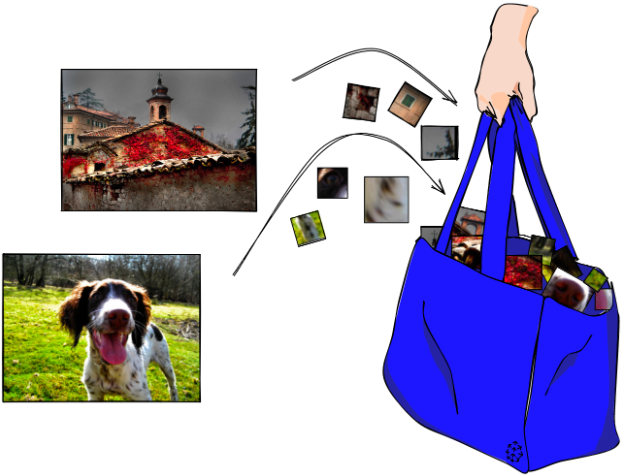

Источник изображения: https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/



### Шаг 1 - Получим изображения и патчи

In [58]:
def get_patches(img_file, random_state, patch_size=(11, 11), n_patches=250):
  img = imageio.imread(img_file)
  # извлечем патчи
  patch = extract_patches_2d(img, patch_size=patch_size, max_patches=n_patches, random_state=random_state)
  return patch.reshape((n_patches, np.prod(patch_size) * len(img.shape)))

Всего изображений:  500
Размер каждого массива патчей:  (100, 7500)


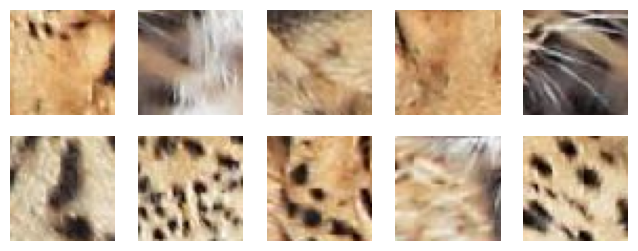

In [60]:
# BOVW parameters
patch_size = (50, 50)
n_patches = 100
path_imgs = '/content/animal_faces_wild'
random_state = 1

# получим список изображений
image_paths = glob(path_imgs + '/*.jpg')
# всего изображений
n_imgs = len(image_paths)

# Извлекаем патчи
patch_arr = Parallel(n_jobs=-1)(delayed(get_patches)(image_path, random_state, patch_size, n_patches) for image_path in image_paths)

print('Всего изображений: ', len(patch_arr))
print('Размер каждого массива патчей: ', patch_arr[0].shape)

# отобразим некоторые патчи
img_ind = 32

plt.figure(figsize=(8,3))
for i in np.arange(1,11):
    plt.subplot(2,5,i)
    plt.imshow(patch_arr[img_ind][i].reshape((patch_size[0], patch_size[1], 3)))
    plt.axis('off')

### Шаг 2 - Извлечение карт признаков из патчей

In [61]:
# определим функцию извлечения признаков, например, LBP
def lbp_features(img, radius=1, sampling_pixels=8):
  # LBP operates in single channel images so if RGB images are provided
  # we have to convert it to grayscale
  if (len(img.shape) > 2):
      img = img.astype(float)
      # RGB to grayscale convertion using Luminance
      img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

  # converting to uint8 type for 256 graylevels
  img = img.astype(np.uint8)

  # normalize values can also help improving description
  i_min = np.min(img)
  i_max = np.max(img)
  if (i_max - i_min != 0):
      img = (img - i_min)/(i_max-i_min)

  # compute LBP
  lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")

  # LBP returns a matrix with the codes, so we compute the histogram
  (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

  # normalization
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-6)

  # return the histogram of Local Binary Patterns
  return hist

In [62]:
patch_arr = np.array(patch_arr, copy=True)
patch_arr = patch_arr.reshape((patch_arr.shape[0] * patch_arr.shape[1], patch_size[0], patch_size[0], 3))

# obtaining features lbp for each patch
patch_lbp = []
for pat in patch_arr:
  f = lbp_features(pat,2,8)
  patch_lbp.append(f)

patch_lbp = np.array(patch_lbp, copy=False)
print('Всего эмбеддингов = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])

Всего эмбеддингов =  50000  size =  10



### Шаг 3 - выучиваем словарь

In [63]:
# размер словаря
n_dic = 50
random_state = 1

# KMeans clustering model
kmeans_model = KMeans(n_clusters=n_dic,
                      verbose=False,
                      init='random',
                      random_state=random_state,
                      n_init=3)
# обучим модель
kmeans_model.fit(patch_lbp)

KMeans(init='random', n_clusters=50, n_init=3, random_state=1, verbose=False)

In [64]:
# посчитаем фичи для каждого изображения
img_feats = []
for i in range(n_imgs):
    # предскажем кластер сразу для нескольких изображений
    y = kmeans_model.predict(patch_lbp[i*n_patches: (i*n_patches)+n_patches])

    # вычислим гистограмму и добавим ее в массив
    hist_bof,_ = np.histogram(y, bins=range(n_dic+1), density=True)
    img_feats.append(hist_bof)

img_feats = np.array(img_feats, copy=False)
print('Число изображений и признаков = ', img_feats.shape)

Число изображений и признаков =  (500, 50)


### Шаг 4 - использование фич для recognition

In [65]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/Panthera_pardus_close_up.jpg/240px-Panthera_pardus_close_up.jpg

--2024-03-12 17:51:27--  https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/Panthera_pardus_close_up.jpg/240px-Panthera_pardus_close_up.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39783 (39K) [image/jpeg]
Saving to: ‘240px-Panthera_pardus_close_up.jpg’

240px-Panthera_pard 100%[===================>]  38.85K  --.-KB/s    in 0.02s   

2024-03-12 17:51:27 (1.97 MB/s) - ‘240px-Panthera_pardus_close_up.jpg’ saved [39783/39783]



<ipython-input-58-5b084140dbf0>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_file)
<ipython-input-66-3154455b9661>:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgq = imageio.imread(path_query)
<ipython-input-66-3154455b9661>:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(image_paths[k_cbir[i]]))


Извлеченные патчи:  (100, 50, 50, 3)


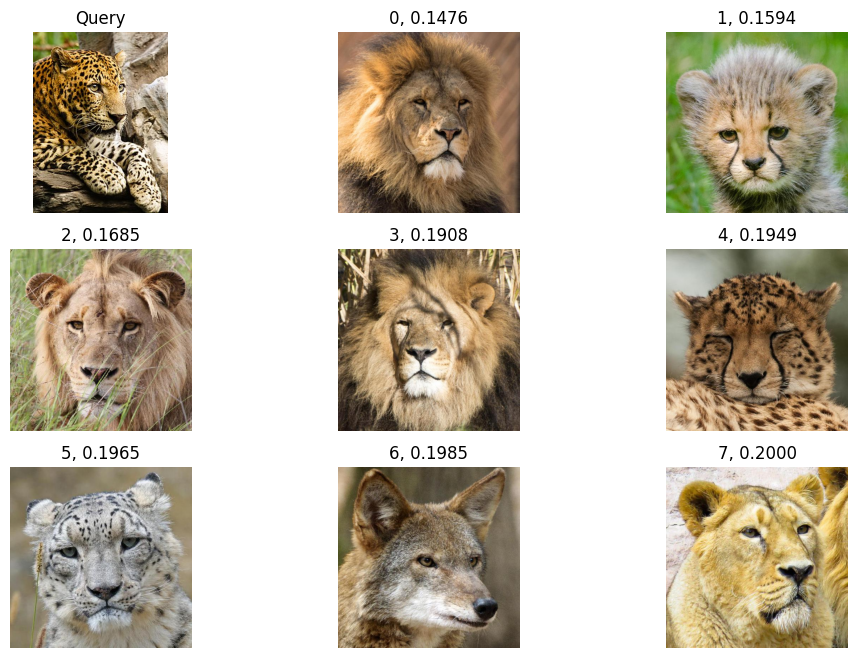

In [66]:
# возьмем картинку для поиска
path_query = '/content/240px-Panthera_pardus_close_up.jpg'

# получим патчи
query_patches = get_patches(path_query, random_state, patch_size, n_patches)
query_patches = np.array(query_patches, copy=False)
query_patches = query_patches.reshape((query_patches.shape[0], patch_size[0], patch_size[0], 3))

print('Извлеченные патчи: ', query_patches.shape)

# получим LBP features
query_lbp = []
for pat in query_patches:
  f = lbp_features(pat,2,8)
  query_lbp.append(f)

query_lbp = np.array(query_lbp, copy=False)

# получим визуальные слова для запроса
y = kmeans_model.predict(query_lbp)
# вычислим дескриптор
query_feats,_ = np.histogram(y, bins=range(n_dic+1), density=True)

# посчитаем евклидовы расстояния
dists = []
for i in range(n_imgs):
  diq = np.sqrt(np.sum((img_feats[i]-query_feats)**2))
  dists.append(diq)

# получим ближайшие кадры
k = 8
k_cbir = np.argsort(dists)[:k]

import imageio
imgq = imageio.imread(path_query)

plt.figure(figsize=(12,8))
plt.subplot(331); plt.imshow(imgq)
plt.title('Query'); plt.axis('off')

imgs = []
for i in range(k):
  imgs.append(imageio.imread(image_paths[k_cbir[i]]))
  plt.subplot(3,3,i+2); plt.imshow(imgs[i])
  plt.title('%d, %.4f' % (i, dists[k_cbir[i]])); plt.axis('off')

## CLIP (https://arxiv.org/abs/2103.00020)
Contrastive Language-Image Pre-**Training**

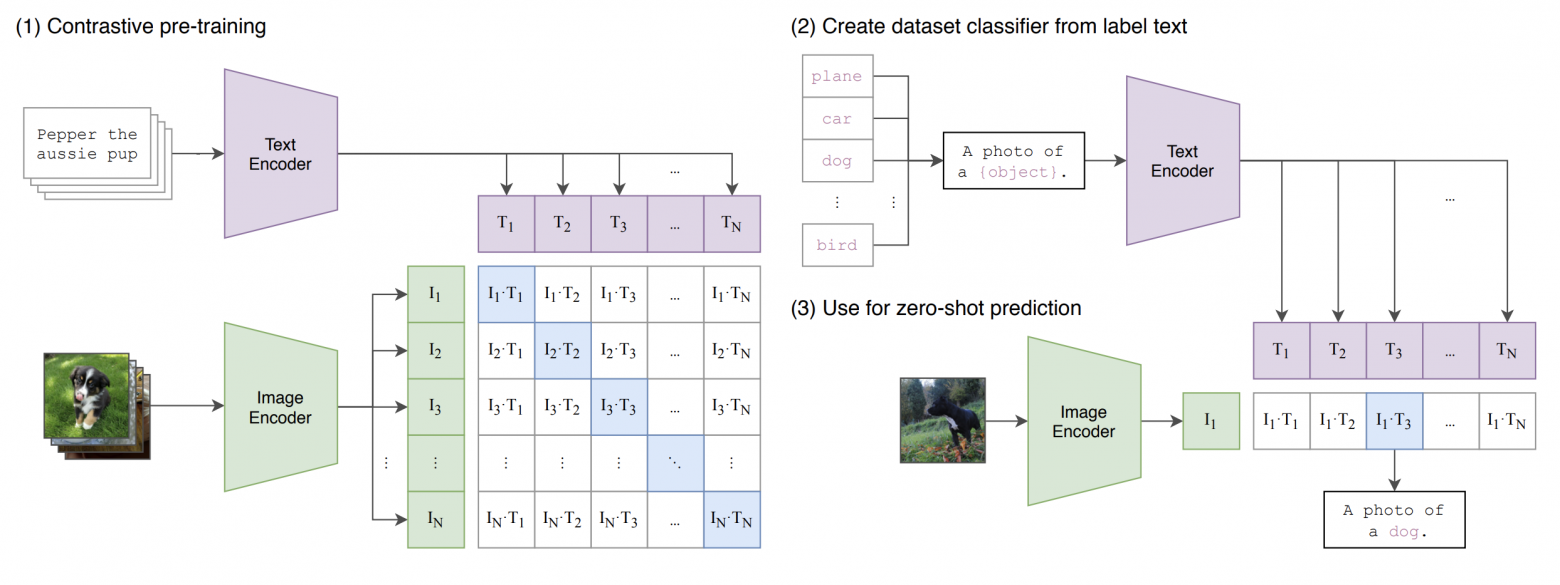

In [67]:
# установим требуемые библиотеки
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ump35e0t
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ump35e0t
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=b3ccebdfc15d011dba797d642cd6ca55cbbcab5b24e952174499125b951f48ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-bhqcts3u/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [68]:
import clip

# посмотрим на доступные претрейны
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [69]:
# инициализируем модель и функцию для препроцессинга
model, preprocess = clip.load("ViT-B/32")

# перенесем модель на видеокарту и переведем в eval-mode
model.cuda().eval()

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 98.3MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [70]:
# посмотрим на функцию препроцессинга
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7992a5d69bd0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [71]:
# используется не чувствительный к регистру токенизатор. По умолчанию выход дополняется до длины 77 токенов
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [72]:
clip.tokenize("Hello")

tensor([[49406,  3306, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [73]:
# проверим работу CLIP на нашем небольшом наборе с лицами животных
text_descriptions = ['a photo of a fox',
                     'a photo of a cheetah',
                     'a photo of a tiger',
                     'a photo of a lion',
                     'a photo of a wolf',
                     'a photo of a leopard']
text_tokens = clip.tokenize(text_descriptions).cuda()

In [74]:
# выберем случайным образом 8 изображений из датасета для визуализации
seed = 12345

image_paths = glob('/content/animal_faces_wild/*.jpg')
random.seed(seed)
cur_image_paths = random.choices(image_paths, k=8)

In [75]:
# соберем списки с исходными изображениями и с их предобработанными версиями
original_images = []
images = []

for image_path in cur_image_paths:
  image = Image.open(image_path).convert("RGB")
  original_images.append(image)
  images.append(preprocess(image))

# подготовим тензор с батчем изображений для подачи в CLIP
image_input = torch.tensor(np.stack(images)).cuda()

In [76]:
# прогоним через feature extractors и нормализуем
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [77]:
# получим матрицу вероятностей
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

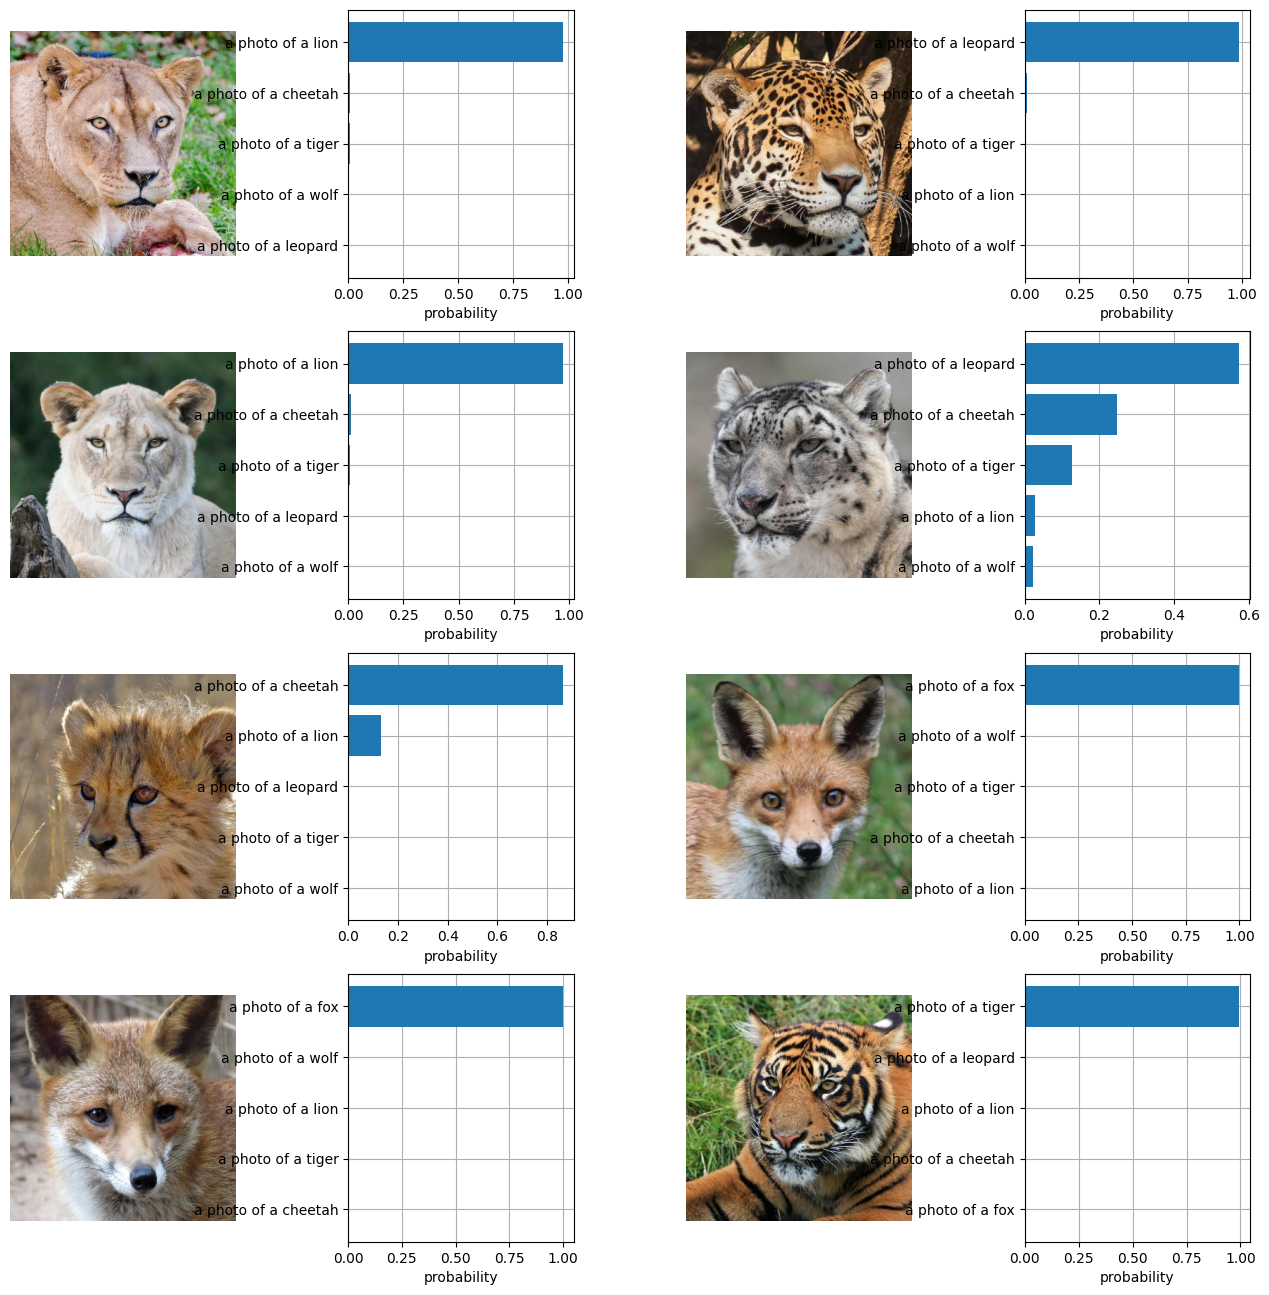

In [78]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [text_descriptions[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

## BLIP (https://arxiv.org/abs/2201.12086v2)
Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation

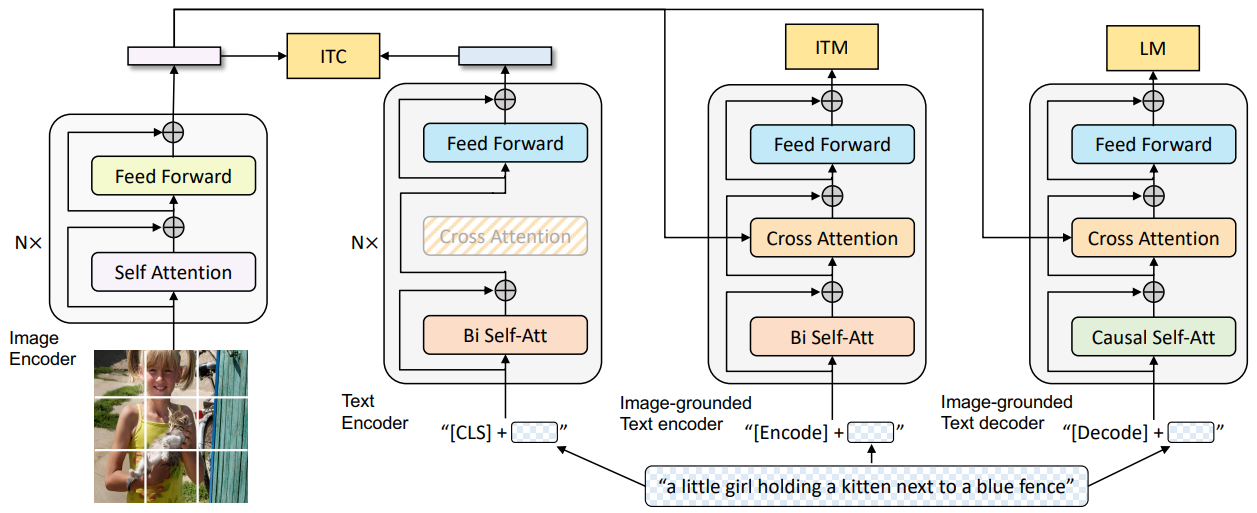

In [79]:
!pip install --user salesforce-lavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 23.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 10.8 MB/s eta 0:00:00
     ━━━━━

In [1]:
import lavis
from lavis.models import load_model_and_preprocess
from lavis.models import model_zoo

print(model_zoo)

Architectures                  Types
albef_classification           ve
albef_feature_extractor        base
albef_nlvr                     nlvr
albef_pretrain                 base
albef_retrieval                coco, flickr
albef_vqa                      vqav2
alpro_qa                       msrvtt, msvd
alpro_retrieval                msrvtt, didemo
blip_caption                   base_coco, large_coco
blip_classification            base
blip_feature_extractor         base
blip_image_text_matching       base, large
blip_nlvr                      nlvr
blip_pretrain                  base
blip_retrieval                 coco, flickr
blip_vqa                       vqav2, okvqa, aokvqa
blip2_opt                      pretrain_opt2.7b, pretrain_opt6.7b, caption_coco_opt2.7b, caption_coco_opt6.7b
blip2_t5                       pretrain_flant5xl, pretrain_flant5xl_vitL, pretrain_flant5xxl, caption_coco_flant5xl
blip2_feature_extractor        pretrain, pretrain_vitL, coco
blip2                      

Image Captioning

In [2]:
device = "cuda:0"
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 2.50G/2.50G [00:36<00:00, 74.1MB/s]


In [5]:
image_paths = glob('/content/animal_faces_wild/*.jpg')

In [6]:
captions = []
for image_path in image_paths[:5]:
  img = Image.open(image_path).convert('RGB')
  img = vis_processors["eval"](img).unsqueeze(0).to(device)
  captions.append(model.generate({"image": img})[0])

In [7]:
def plot_images(y_paths, y_titles):
  fig = plt.figure(figsize=(15,15), dpi=100)
  rows, cols = 3, 2

  for i, path in enumerate(y_paths[:rows*cols]):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, (224, 224))

    fig.add_subplot(rows, cols, i+1)
    plt.title(y_titles[i])
    plt.imshow(img)
    plt.axis('off')

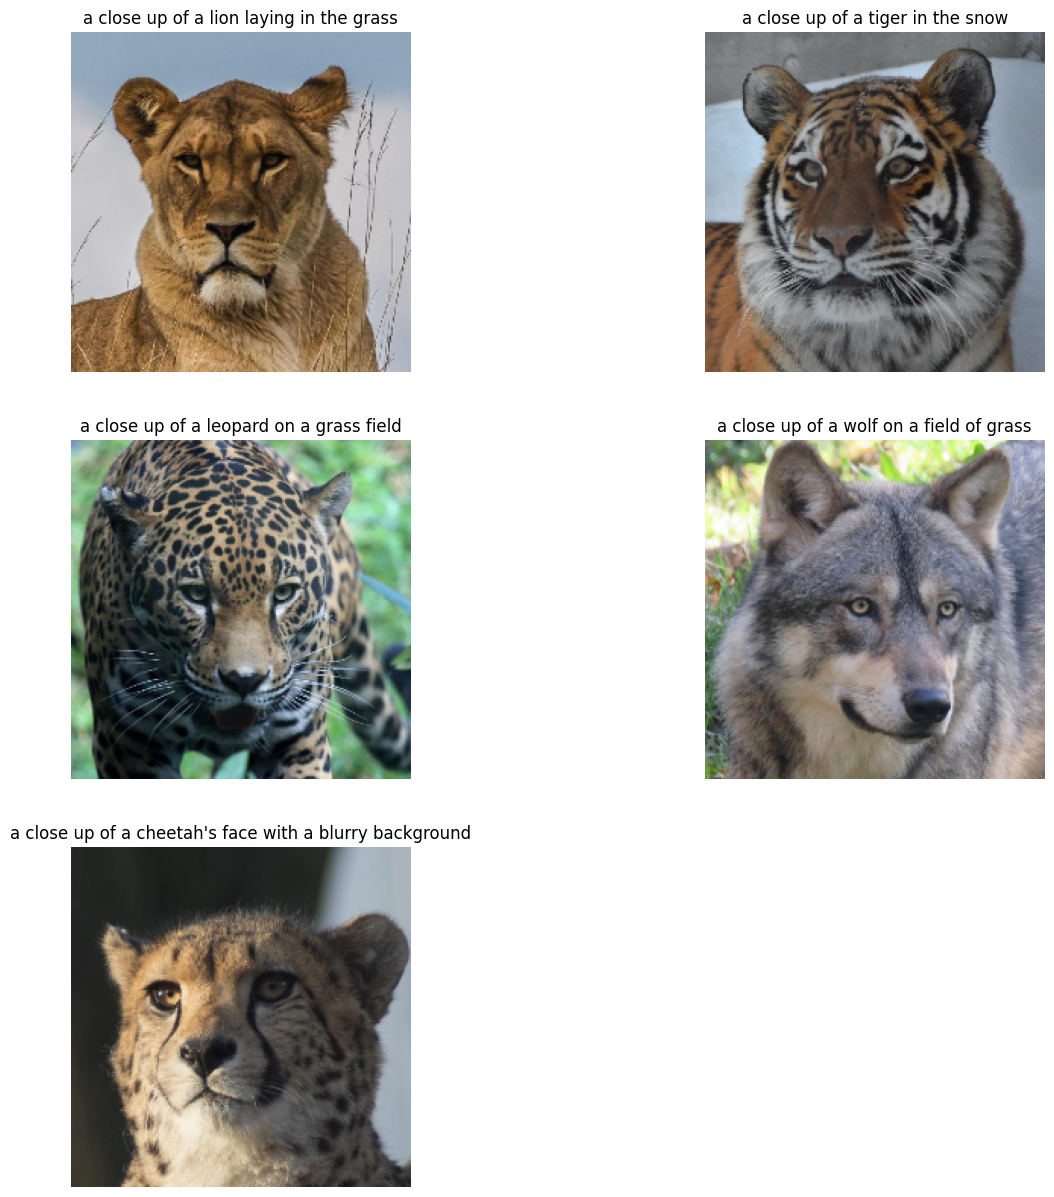

In [8]:
plot_images(image_paths[:5], captions)

Visual Query Answering (VQA)

In [9]:
model, vis_preprocessors, txt_preprocessors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device)

100%|██████████| 1.35G/1.35G [00:17<00:00, 84.3MB/s]


In [10]:
question = "Which animal is shown in the photo?"

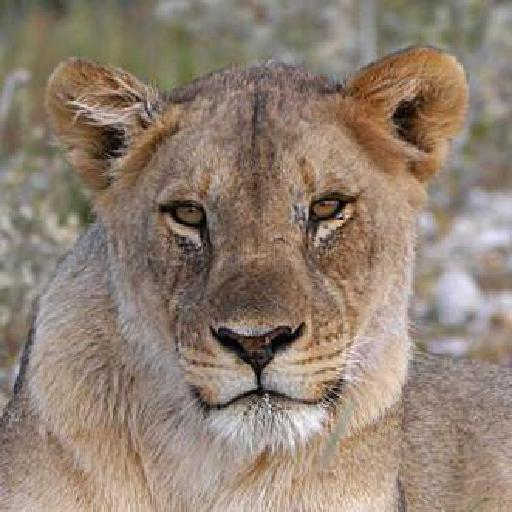

In [ ]:
path = '/content/animal_faces_wild/flickr_wild_003231.jpg'
img = Image.open(path).convert('RGB')
img

In [ ]:
image = vis_preprocessors["eval"](img).unsqueeze(0).to(device)
question = txt_preprocessors["eval"](question)

In [ ]:
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

['lion']

Посмотрим на другом примере

In [ ]:
!wget https://studyinrussia.ru/upload/iblock/9ba/9ba352b66a87c277149e97e2e74fd8c2.jpg

--2024-03-11 22:48:02--  https://studyinrussia.ru/upload/iblock/9ba/9ba352b66a87c277149e97e2e74fd8c2.jpg
Resolving studyinrussia.ru (studyinrussia.ru)... 37.18.87.162
Connecting to studyinrussia.ru (studyinrussia.ru)|37.18.87.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312797 (305K) [image/jpeg]
Saving to: ‘9ba352b66a87c277149e97e2e74fd8c2.jpg’

9ba352b66a87c277149 100%[===================>] 305.47K  1.69MB/s    in 0.2s    

2024-03-11 22:48:03 (1.69 MB/s) - ‘9ba352b66a87c277149e97e2e74fd8c2.jpg’ saved [312797/312797]



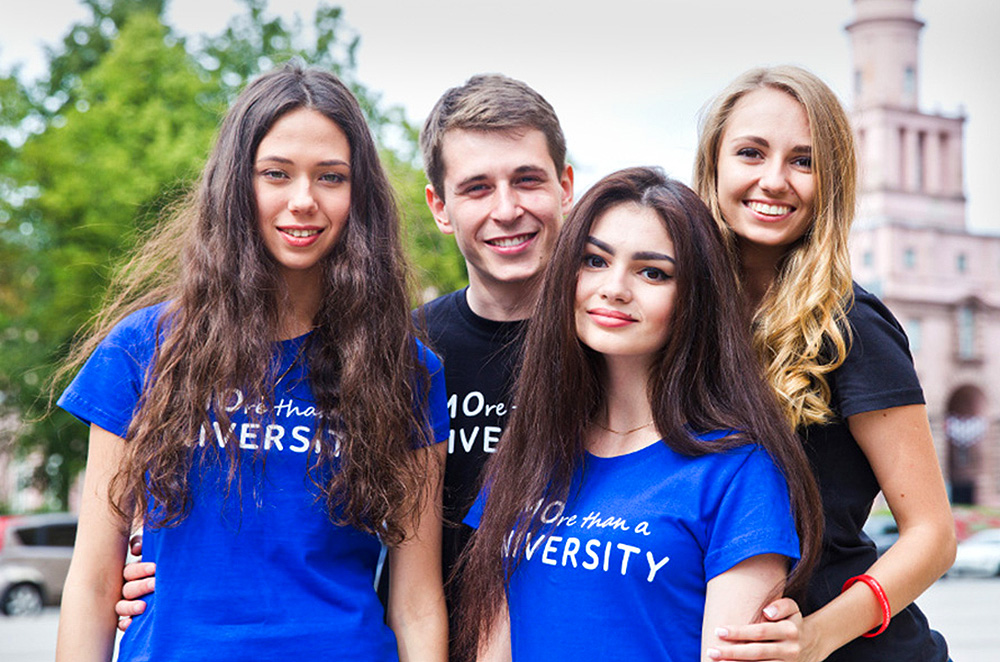

In [ ]:
path = "/content/9ba352b66a87c277149e97e2e74fd8c2.jpg"
img = Image.open(path).convert('RGB')
img

In [ ]:
question = "How many persons are in the photo?"

In [ ]:
image = vis_preprocessors["eval"](img).unsqueeze(0).to(device)
question = txt_preprocessors["eval"](question)

In [ ]:
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

['4']

Feature extraction

In [ ]:
model, vis_preprocessors, txt_preprocessors = load_model_and_preprocess(name="blip2_feature_extractor", model_type="pretrain", is_eval=True, device=device)

100%|██████████| 1.89G/1.89G [00:47<00:00, 42.5MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 712M/712M [00:18<00:00, 39.6MB/s]


In [ ]:
captions

['a close up of a white wolf with blue eyes',
 'a close up of a red fox with blue eyes',
 'a close up of a leopard looking at the camera',
 'a close up of a leopard on a field of grass',
 'a young lion cub looking at the camera']

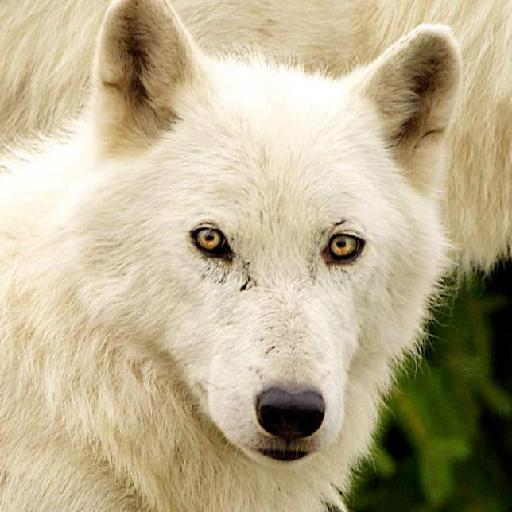

In [ ]:
img = Image.open(image_paths[0]).convert('RGB')
img

In [ ]:
image = vis_preprocessors["eval"](img).unsqueeze(0).to(device)
text_input = txt_preprocessors["eval"](captions[0])
sample = {"image": image, "text_input": [text_input]}

In [ ]:
features_multimodal = model.extract_features(sample)
print(features_multimodal.multimodal_embeds.shape)

torch.Size([1, 32, 768])


In [ ]:
features_multimodal

BlipOutputFeatures(image_embeds=None, image_embeds_proj=None, text_embeds=None, text_embeds_proj=None, multimodal_embeds=tensor([[[ 0.1510, -0.4581,  0.0764,  ..., -0.3818,  0.5659,  0.0706],
         [ 0.2347, -0.7165,  0.1098,  ..., -0.3295,  0.6722,  0.1861],
         [ 0.1540, -0.4852,  0.1370,  ..., -0.3338,  0.7068,  0.0914],
         ...,
         [ 0.2400, -0.4883,  0.1128,  ..., -0.3248,  0.6534,  0.1215],
         [ 0.3380, -0.0136,  0.2626,  ..., -0.2176,  0.5532, -0.0818],
         [ 0.2657, -0.6281,  0.0908,  ..., -0.3326,  0.7423,  0.1860]]],
       device='cuda:0'))

In [ ]:
features_image = model.extract_features(sample, mode="image")
features_text = model.extract_features(sample, mode="text")
print(features_image.image_embeds.shape, features_text.text_embeds.shape)

torch.Size([1, 32, 768]) torch.Size([1, 12, 768])
